<a href="https://colab.research.google.com/github/divyakumar95/ProgrammingDA_CA/blob/main/Prog_Da_CA02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%sh
curl https://packages.microsoft.com/keys/microsoft.asc | apt-key add -
curl https://packages.microsoft.com/config/ubuntu/16.04/prod.list > /etc/apt/sources.list.d/mssql-release.list
sudo apt-get update
sudo ACCEPT_EULA=Y apt-get -q -y install msodbcsql17

In [ ]:
!pip -q install pypyodbc

Add API key path

In [170]:
import requests,json

api_key_path = '/content/drive/MyDrive/DataAnalytics/tmdb_apikey.txt'
with open(api_key_path,'r+') as f:
  api_key = f.read()

Define pull data function --> Input number of pages to get from API

In [171]:
def pull_data(pages):
  resp_list = []
  for i in range(1,pages):
    Full_url = 'https://api.themoviedb.org/3/movie/top_rated?api_key='+api_key+'&language=en-US&page='+str(i)
    resp = requests.get(Full_url)
    x = resp.json()
    resp_list.append(x)
  return resp_list

resp = pull_data(20)

Checking all the columns present in results

In [172]:
data_columns = resp[0]['results'][0].keys()
print(data_columns)

dict_keys(['adult', 'backdrop_path', 'genre_ids', 'id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'release_date', 'title', 'video', 'vote_average', 'vote_count'])


Creating empty dataframe withe the required columns

In [173]:
import pandas as pd
emptyDf = pd.DataFrame(columns=data_columns)
emptyDf

,adult,backdrop_path,genre_ids,id,original_language,original_title,overview,popularity,poster_path,release_date,title,video,vote_average,vote_count


Push all the data into the dataframe

In [306]:
def inserting_data(a,pd_data):
  for i in range(len(a)):
    for j in range(len(a[i]['results'])):
      hel = a[i]['results'][j]
      pd_data = pd_data.append(hel, ignore_index=True)
  return pd_data

data = inserting_data(resp,emptyDf)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   adult              380 non-null    object 
 1   backdrop_path      378 non-null    object 
 2   genre_ids          380 non-null    object 
 3   id                 380 non-null    object 
 4   original_language  380 non-null    object 
 5   original_title     380 non-null    object 
 6   overview           380 non-null    object 
 7   popularity         380 non-null    float64
 8   poster_path        380 non-null    object 
 9   release_date       380 non-null    object 
 10  title              380 non-null    object 
 11  video              380 non-null    object 
 12  vote_average       380 non-null    float64
 13  vote_count         380 non-null    object 
dtypes: float64(2), object(12)
memory usage: 41.7+ KB


### Columns Description
* poster_path: movie poster path
* adult: Adult type movie - Boolean 
* overview: Movie Overview
* release_date: Movie release date
* genre_ids: Movie Genre
* id: unique movie ids
* original_title: Movie original title
* original_language: Movie language
* title: Movie title
* backdrop_path: Movie background poster for webpage path
* popularity: Movie Popularity
* vote_count: Number of votes for movie
* video: check for trailer - Boolean
* vote_average: Average votes

Genre Ids description: (Source - https://www.themoviedb.org/talk/5daf6eb0ae36680011d7e6ee)

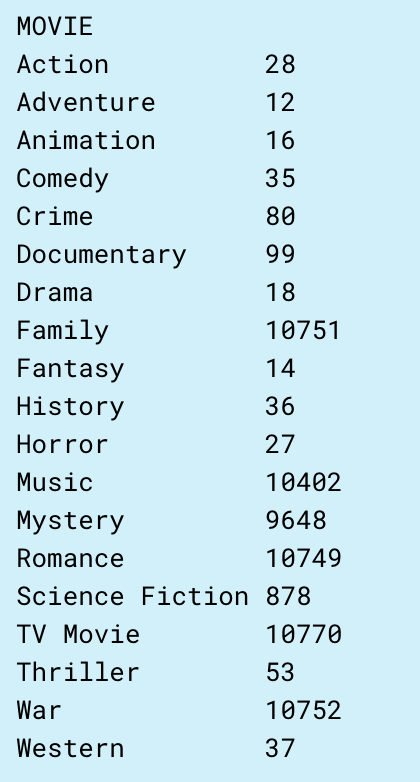

In [307]:
data.tail(2)

,adult,backdrop_path,genre_ids,id,original_language,original_title,overview,popularity,poster_path,release_date,title,video,vote_average,vote_count
378,False,/umUyVxJ4HeNebLMAcScdhF0QB3h.jpg,"[18, 36]",76203,en,12 Years a Slave,"In the pre-Civil War United States, Solomon No...",23.624,/xdANQijuNrJaw1HA61rDccME4Tm.jpg,2013-10-18,12 Years a Slave,False,7.9,9333
379,False,/7amSQSipxgiQnEejWX6iQonFrZI.jpg,"[18, 10749]",946,en,Letter from an Unknown Woman,A pianist about to flee from a duel receives a...,6.195,/54JBMKw2uREbDviTvCerAePkzda.jpg,1948-04-28,Letter from an Unknown Woman,False,7.9,206


In [313]:
genre_df = pd.concat([data['genre_ids'],data['id']],axis=1) #data['genre_ids'] #.to_list()

In [337]:
genre_columns = { 
 28:'Action',
 12:'Adventure',
 16:'Animation',
 35:'Comedy',
 80:'Crime',
 99:'Documentary',
 18:'Drama',
 10751:'Family',
 14:'Fantasy',
 36:'History',
 27:'Horror',
 10402:'Music',
 9648:'Mystery',
 10749:'Romance',
 878:'Science Fiction',
 10770:'TV Movie',
 53:'Thriller',
 10752:'War',
 37:'Western'
}

In [314]:
df_melt = genre_df.assign(names=genre_df.genre_ids.str.split(","))
df_melt = df_melt.genre_ids.apply(pd.Series) \
    .merge(df_melt, right_index=True, left_index=True) \
    .drop(["genre_ids"], axis=1) \
    .melt(id_vars=['id'], value_name="genre_ids") \
    .drop("variable", axis=1) \
    .dropna()
  
df_melt.head()

,id,genre_ids
0,19404,35.0
1,278,18.0
2,238,18.0
3,634649,28.0
4,724089,10749.0


In [315]:
df_explode = genre_df.assign(names=genre_df.genre_ids.str.split(",")).explode('genre_ids')
df_explode.head()

,genre_ids,id,names
0,35,19404,NaN
0,18,19404,NaN
0,10749,19404,NaN
1,18,278,NaN
1,80,278,NaN


In [316]:
df_explode['genre_ids'].unique()

array([35, 18, 10749, 80, 28, 12, 878, 36, 10752, 16, 10751, 14, 53,
       10402, 37, 27, 10770, 9648], dtype=object)

In [317]:
len(df_explode['id'].unique())

380

In [318]:
#df_explode = df_explode.fillna(1)
df_explode = df_explode.drop('names',axis=1)

In [319]:
df_explode.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 959 entries, 0 to 379
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   genre_ids  959 non-null    object
 1   id         959 non-null    object
dtypes: object(2)
memory usage: 22.5+ KB


In [320]:
pd.to_numeric(df_explode['genre_ids'])

0         35
0         18
0      10749
1         18
1         80
       ...  
377       36
378       18
378       36
379       18
379    10749
Name: genre_ids, Length: 959, dtype: int64

In [321]:
pd.to_numeric(df_explode['id'])

0       19404
0       19404
0       19404
1         278
1         278
        ...  
377    152532
378     76203
378     76203
379       946
379       946
Name: id, Length: 959, dtype: int64

In [327]:
geners = df_explode.pivot(columns=['genre_ids']) #,index=['id']) #'genre_ids',['id'])

In [328]:
geners.shape

(380, 18)

In [329]:
geners.columns = geners.columns.droplevel()
geners.head()

genre_ids,12,14,16,18,27,28,35,36,37,53,80,878,9648,10402,10749,10751,10752,10770
0,NaN,NaN,NaN,19404,NaN,NaN,19404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19404,NaN,NaN,NaN
1,NaN,NaN,NaN,278,NaN,NaN,NaN,NaN,NaN,NaN,278,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,238,NaN,NaN,NaN,NaN,NaN,NaN,238,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,634649,NaN,NaN,NaN,NaN,634649,NaN,NaN,NaN,NaN,NaN,634649,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,724089,NaN,NaN,NaN


In [330]:
#geners = geners.fillna(0)
geners.head()

genre_ids,12,14,16,18,27,28,35,36,37,53,80,878,9648,10402,10749,10751,10752,10770
0,NaN,NaN,NaN,19404,NaN,NaN,19404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19404,NaN,NaN,NaN
1,NaN,NaN,NaN,278,NaN,NaN,NaN,NaN,NaN,NaN,278,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,238,NaN,NaN,NaN,NaN,NaN,NaN,238,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,634649,NaN,NaN,NaN,NaN,634649,NaN,NaN,NaN,NaN,NaN,634649,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,724089,NaN,NaN,NaN


In [331]:
geners = geners>1
newgeners = geners.replace([False],  0)

In [340]:
newgeners = newgeners.rename(columns=genre_columns)

In [341]:
newgeners.head()

genre_ids,Adventure,Fantasy,Animation,Drama,Horror,Action,Comedy,History,Western,Thriller,Crime,Science Fiction,Mystery,Music,Romance,Family,War,TV Movie
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [342]:
newdata = pd.concat([data,newgeners],axis=1)
newdata.head()

,adult,backdrop_path,genre_ids,id,original_language,original_title,overview,popularity,poster_path,release_date,title,video,vote_average,vote_count,Adventure,Fantasy,Animation,Drama,Horror,Action,Comedy,History,Western,Thriller,Crime,Science Fiction,Mystery,Music,Romance,Family,War,TV Movie
0,False,/5hNcsnMkwU2LknLoru73c76el3z.jpg,"[35, 18, 10749]",19404,hi,दिलवाले दुल्हनिया ले जायेंगे,"Raj is a rich, carefree, happy-go-lucky second...",20.077,/2CAL2433ZeIihfX1Hb2139CX0pW.jpg,1995-10-20,Dilwale Dulhania Le Jayenge,False,8.7,3283,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,False,/iNh3BivHyg5sQRPP1KOkzguEX0H.jpg,"[18, 80]",278,en,The Shawshank Redemption,Framed in the 1940s for the double murder of h...,61.015,/q6y0Go1tsGEsmtFryDOJo3dEmqu.jpg,1994-09-23,The Shawshank Redemption,False,8.7,20308,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,False,/rSPw7tgCH9c6NqICZef4kZjFOQ5.jpg,"[18, 80]",238,en,The Godfather,"Spanning the years 1945 to 1955, a chronicle o...",60.333,/eEslKSwcqmiNS6va24Pbxf2UKmJ.jpg,1972-03-14,The Godfather,False,8.7,15188,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,False,/VlHt27nCqOuTnuX6bku8QZapzO.jpg,"[28, 12, 878]",634649,en,Spider-Man: No Way Home,Peter Parker is unmasked and no longer able to...,21848.810,/1g0dhYtq4irTY1GPXvft6k4YLjm.jpg,2021-12-15,Spider-Man: No Way Home,False,8.7,1414,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,False,/jtAI6OJIWLWiRItNSZoWjrsUtmi.jpg,[10749],724089,en,Gabriel's Inferno Part II,Professor Gabriel Emerson finally learns the t...,32.425,/x5o8cLZfEXMoZczTYWLrUo1P7UJ.jpg,2020-07-31,Gabriel's Inferno Part II,False,8.7,1353,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [343]:
newdata = newdata.drop(['backdrop_path','genre_ids','poster_path','overview','original_title'],axis=1)

In [344]:
newdata.head()

,adult,id,original_language,popularity,release_date,title,video,vote_average,vote_count,Adventure,Fantasy,Animation,Drama,Horror,Action,Comedy,History,Western,Thriller,Crime,Science Fiction,Mystery,Music,Romance,Family,War,TV Movie
0,False,19404,hi,20.077,1995-10-20,Dilwale Dulhania Le Jayenge,False,8.7,3283,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,False,278,en,61.015,1994-09-23,The Shawshank Redemption,False,8.7,20308,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,False,238,en,60.333,1972-03-14,The Godfather,False,8.7,15188,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,False,634649,en,21848.810,2021-12-15,Spider-Man: No Way Home,False,8.7,1414,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,False,724089,en,32.425,2020-07-31,Gabriel's Inferno Part II,False,8.7,1353,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [347]:
newdata['release_date'] = pd.to_datetime(newdata["release_date"])

In [348]:
newdata.head(2)

,adult,id,original_language,popularity,release_date,title,video,vote_average,vote_count,Adventure,Fantasy,Animation,Drama,Horror,Action,Comedy,History,Western,Thriller,Crime,Science Fiction,Mystery,Music,Romance,Family,War,TV Movie
0,False,19404,hi,20.077,1995-10-20,Dilwale Dulhania Le Jayenge,False,8.7,3283,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,False,278,en,61.015,1994-09-23,The Shawshank Redemption,False,8.7,20308,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Check for Nan's in dataset

In [349]:
newdata.isna().sum()

adult                0
id                   0
original_language    0
popularity           0
release_date         0
title                0
video                0
vote_average         0
vote_count           0
Adventure            0
Fantasy              0
Animation            0
Drama                0
Horror               0
Action               0
Comedy               0
History              0
Western              0
Thriller             0
Crime                0
Science Fiction      0
Mystery              0
Music                0
Romance              0
Family               0
War                  0
TV Movie             0
dtype: int64

In [351]:
newdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   adult              380 non-null    object        
 1   id                 380 non-null    object        
 2   original_language  380 non-null    object        
 3   popularity         380 non-null    float64       
 4   release_date       380 non-null    datetime64[ns]
 5   title              380 non-null    object        
 6   video              380 non-null    object        
 7   vote_average       380 non-null    float64       
 8   vote_count         380 non-null    object        
 9   Adventure          380 non-null    float64       
 10  Fantasy            380 non-null    float64       
 11  Animation          380 non-null    float64       
 12  Drama              380 non-null    float64       
 13  Horror             380 non-null    float64       
 14  Action    

In [352]:
import matplotlib.pyplot as plt
import numpy as np

def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

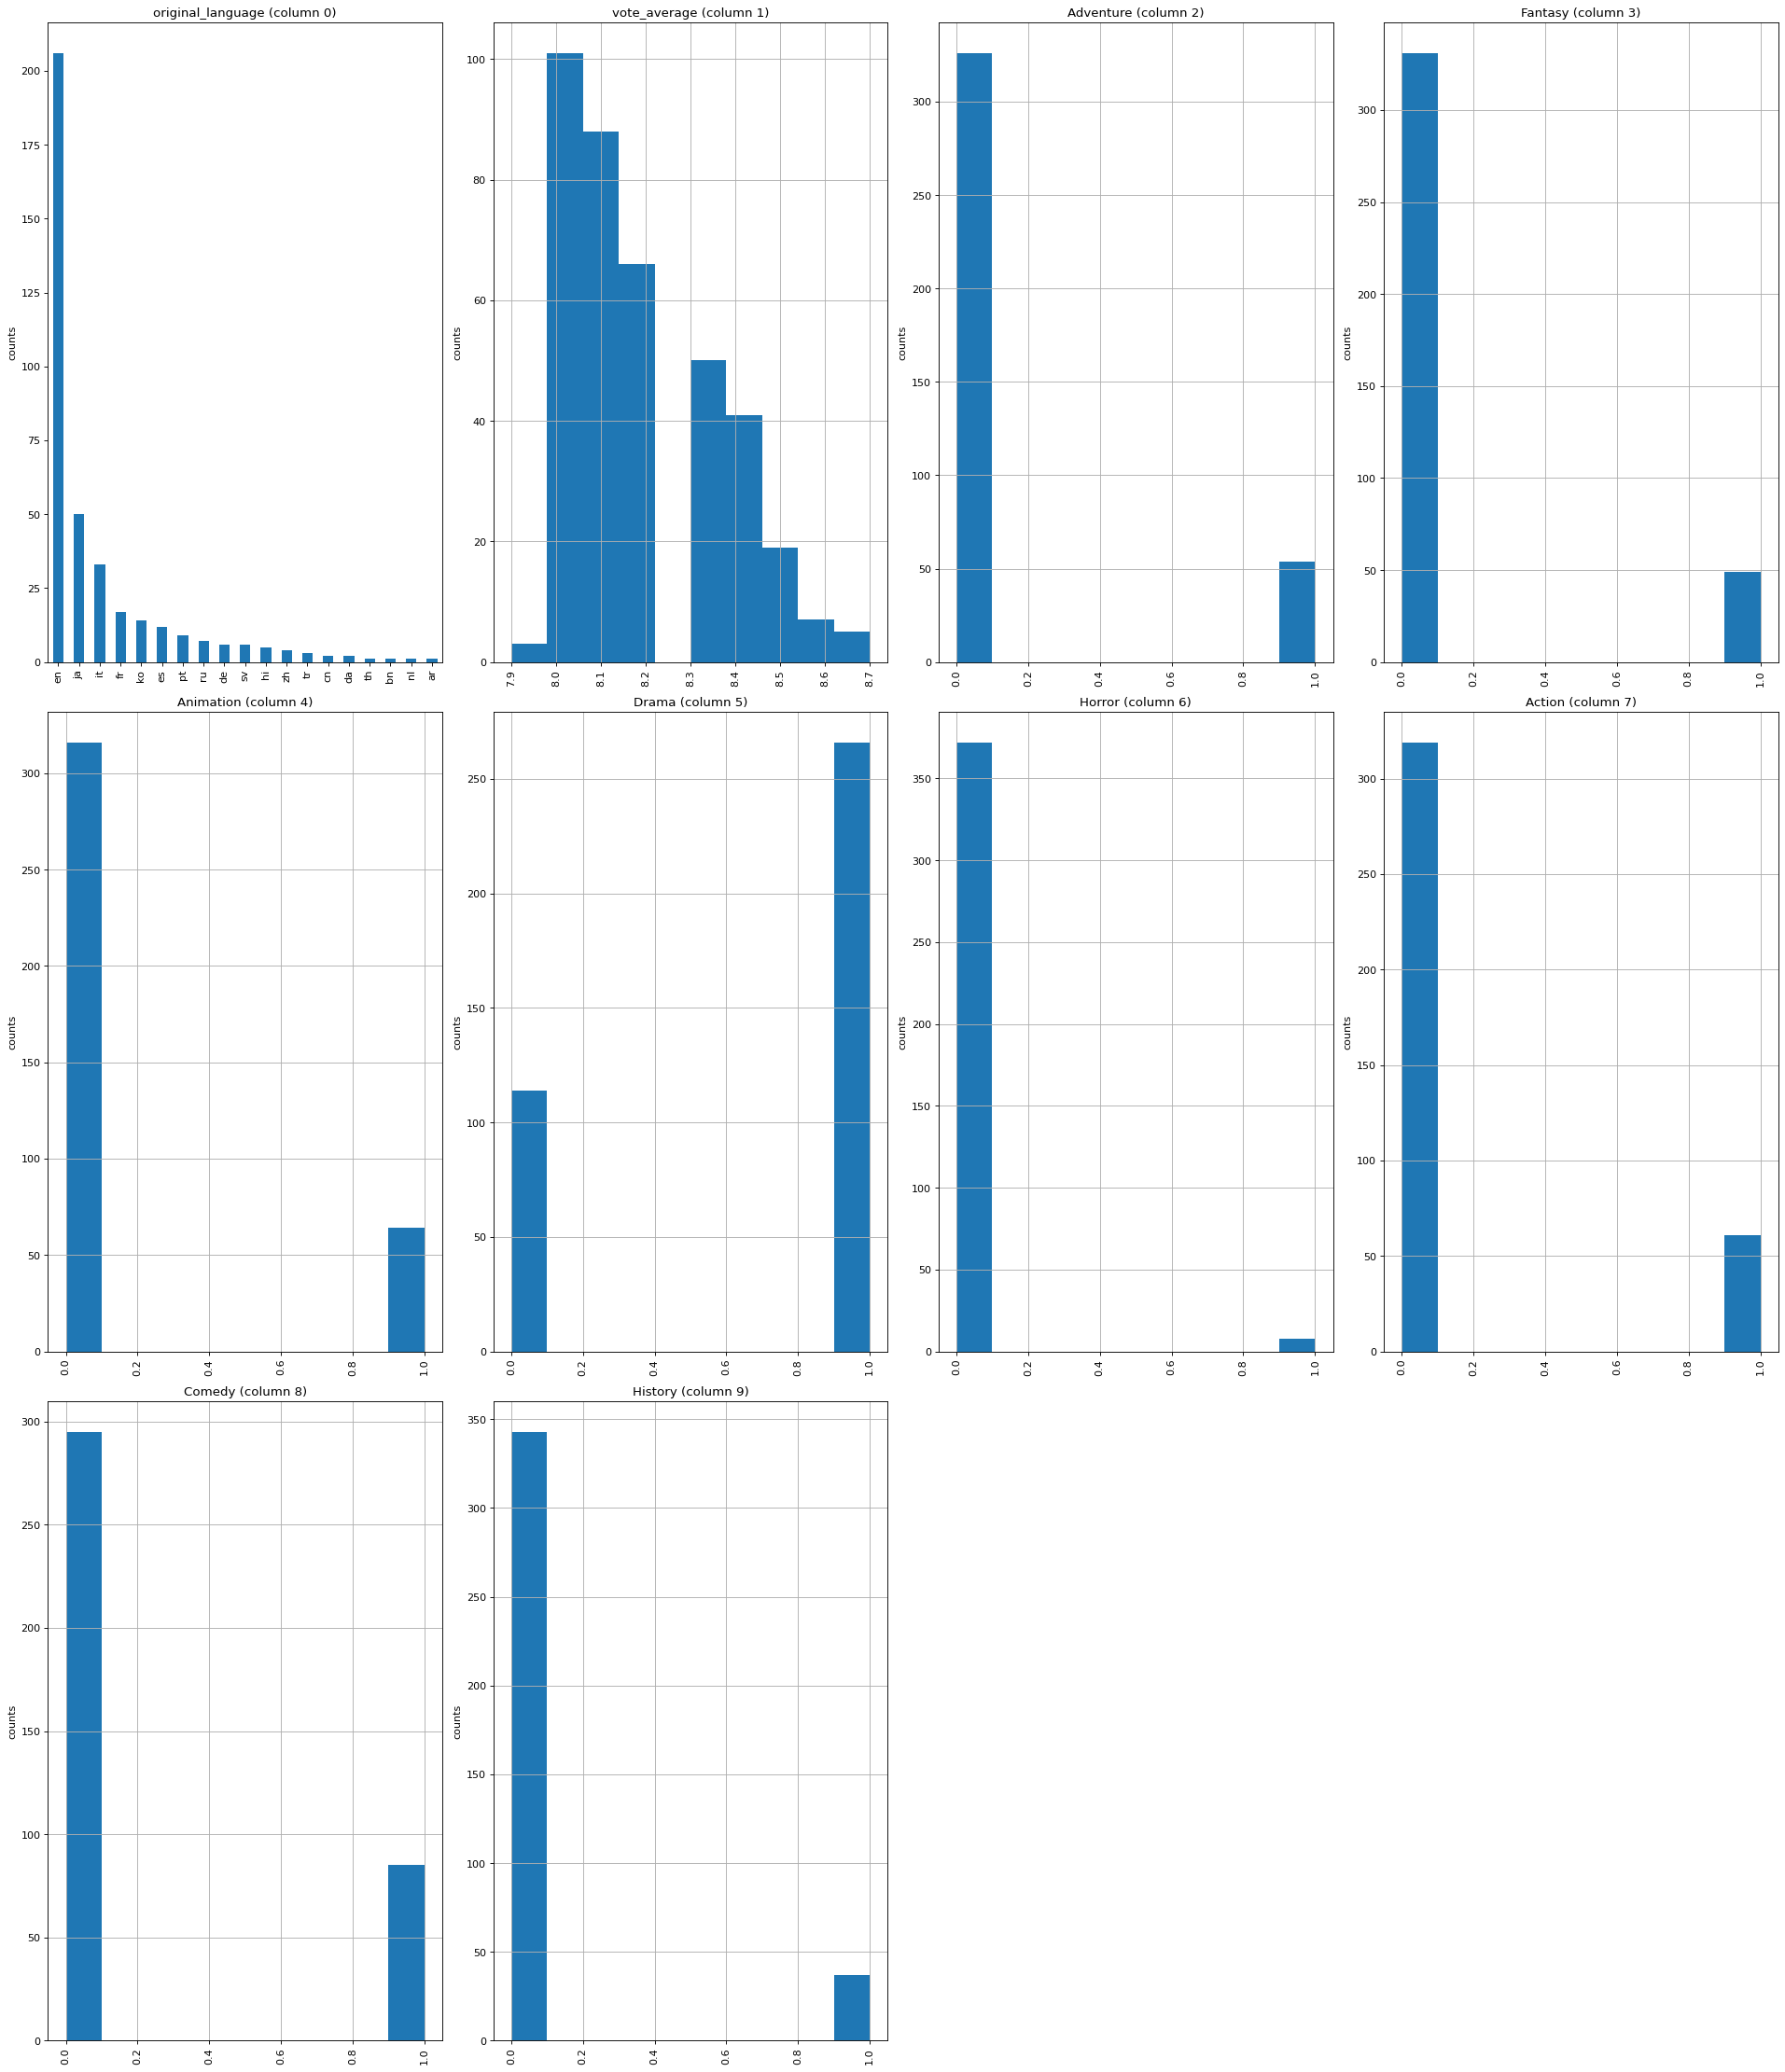

In [354]:
plotPerColumnDistribution(newdata, 10, 4)

In [355]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth, db):
    filename = db
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

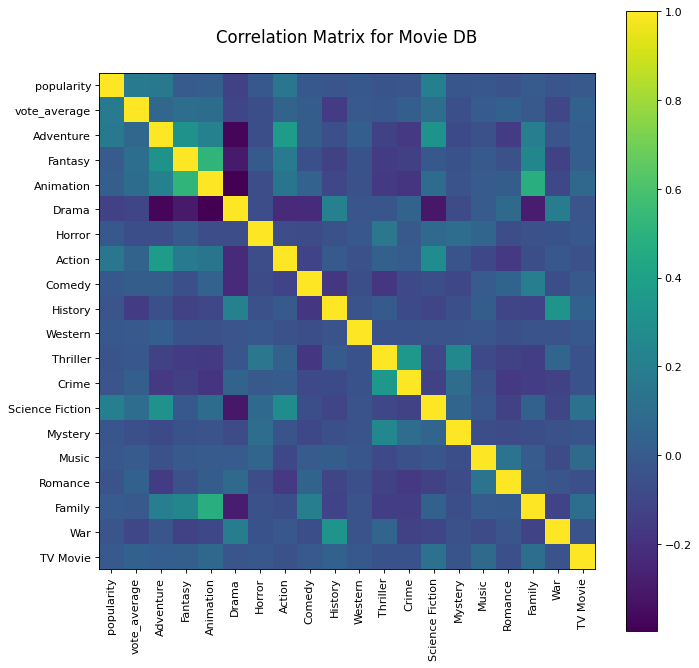

In [356]:
plotCorrelationMatrix(newdata,10,'Movie DB')

In [357]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

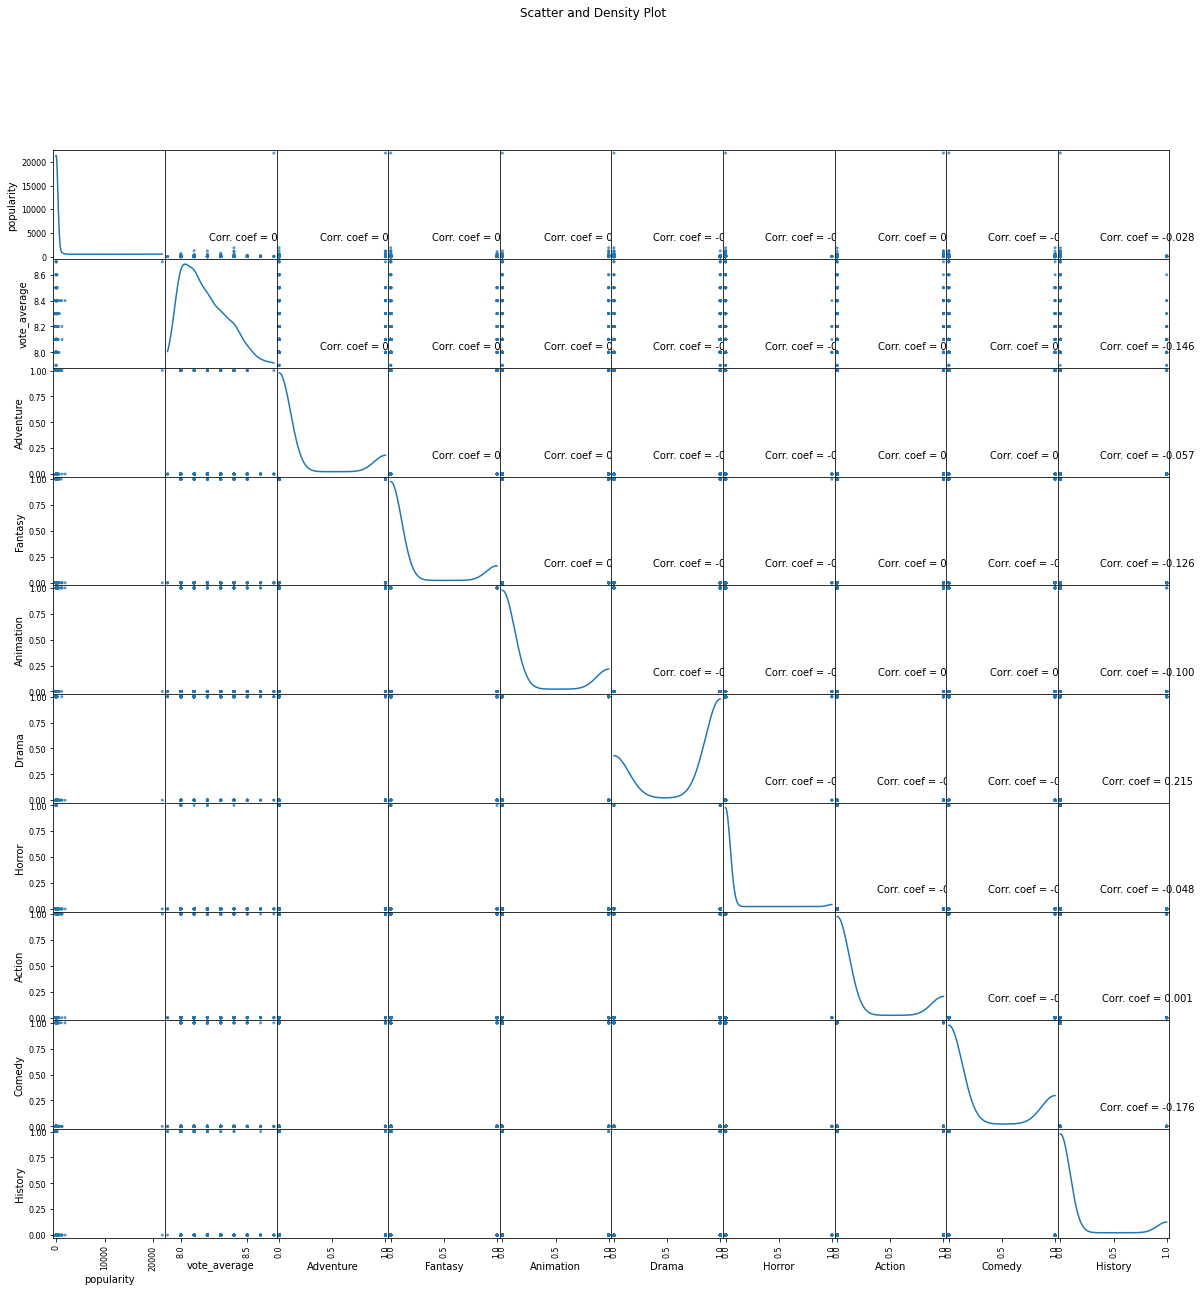

In [358]:
plotScatterMatrix(newdata, 20, 10)